# BigDFT Fragmentation 

In this notebook we will go through the steps needed for computing the purity indicator and spillage values. First, we define the calculator we will use.

In [13]:
from BigDFT import Calculators as C
from BigDFT import PostProcessing as PP
from BigDFT import Fragments as F
from BigDFT import Atom as A
from BigDFT import Logfiles as L
from BigDFT import Inputfiles as I
reload(C)
reload(PP)
reload(F)
reload(A)
reload(L)
reload(I)

<module 'BigDFT.Inputfiles' from '/Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/lib/python2.7/site-packages/BigDFT/Inputfiles.pyc'>

In [14]:
code = C.SystemCalculator(omp=2, mpi_run="mpirun")

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft


In [15]:
code.update_global_options(skip=True)

We will store the results and inputs in a dictionary for naming ease.

In [16]:
rundir = "spillage_dir"

We will store the results and inputs in a class for naming ease.

In [17]:
class Result:
    def __init__(self, log=None, system=None, inp=None):
        self.log = log
        self.system = system
        self.inp = inp

## Setup Calculation

First we define the system, which will be three water molecules. Two are close together, and one is far away..

In [18]:
full = Result()
full.sys = F.System()
full.sys["FULL:1"] = F.Fragment()
full.sys["FULL:1"].append({"O":[-0.931477999671, 0.004547999723, -0.117331000086], "units":"angstroem"})
full.sys["FULL:1"].append({"H":[-1.355753693973, -0.032108553467, 0.725181911626], "units":"angstroem"})
full.sys["FULL:1"].append({"H":[-0.003078395366, 0.011003111969, 0.053703839371], "units":"angstroem"})
full.sys["FULL:1"].append({"O":[1.500000000000, -0.003706000000, 0.113495000000], "units":"angstroem"})
full.sys["FULL:1"].append({"H":[1.796831000000, 0.762122000000, -0.351887000000], "units":"angstroem"})
full.sys["FULL:1"].append({"H":[1.773536000000, -0.747744000000, -0.399151000000], "units":"angstroem"})
full.sys["FULL:1"].append({"O":[10.500000000000, -0.003706000000, 0.113495000000], "units":"angstroem"})
full.sys["FULL:1"].append({"H":[10.796831000000, 0.762122000000, -0.351887000000], "units":"angstroem"})
full.sys["FULL:1"].append({"H":[10.773536000000, -0.747744000000, -0.399151000000], "units":"angstroem"})

We will next define an input file for doing a calculation.

In [19]:
full.inp = I.Inputfile()
full.inp.set_xc("PBE")
full.inp.set_hgrid(0.4)
full.inp.write_orbitals_on_disk()
full.inp.calculate_dipole()
full.inp["import"] = "linear"
full.inp["posinp"] = {"units":"angstroem", "positions":full.sys.get_posinp("angstroem")}

In [20]:
full.log = code.run(name="full", input=full.inp, run_dir=rundir)

Creating the yaml input file "spillage_dir/full.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n full -s Yes


## Fragmentation Study
In our initial calculation, we setup a system as just one large fragment. Now we will look at dividing a system into smaller parts and use the multipole information to guide this approach. First, let's consider breaking the system into individual atoms.

In [21]:
btool = PP.BigDFTool()

In [22]:
atsys = F.System()
atoms = ["O:1", "H:2", "H:3", "O:4", "H:5", "H:6", "O:7", "H:8", "H:9"]
for label, atom in zip(atoms, full.sys["FULL:1"]):
    atsys[label] = F.Fragment([atom])

In [23]:
btool.set_fragment_multipoles(atsys, full.log)

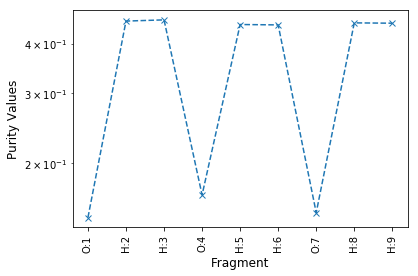

In [25]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,1)
atsys.plot_purity(axs)

Clearly the choice of atoms as a partitioning of the system is inadequate. Instead, we can refragment based on actual water molecules.

In [26]:
molsys = F.System()
molsys["WAT:1"] = full.sys["FULL:1"][0:3]
molsys["WAT:2"] = full.sys["FULL:1"][3:6]
molsys["WAT:3"] = full.sys["FULL:1"][6:]
btool.set_fragment_multipoles(molsys, full.log)

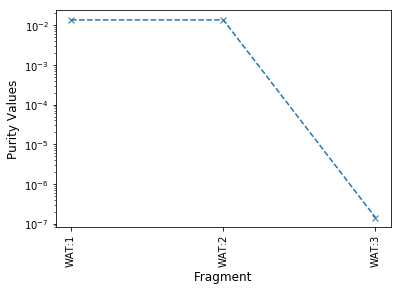

In [27]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,1)
molsys.plot_purity(axs)

Indeed we see that the water molecules themselves are much purer than the individual atoms, making them much more suitable fragments of a system. 

## QM/MM Setup
Now let's assume that we want to do a a QM/MM calculation that accurately computes the values associated with the first water molecule. First, let's do a calculation where we only treat the first water molecule in a QM way. First we partition, and then use that to build a new input file.

In [28]:
def setup_qmmm(startsys, startinp, targets):
    from copy import deepcopy
    env = deepcopy(startsys)
    QM = F.System()
    for t in targets:
        QM[t] = env.pop(t)
    
    inp = deepcopy(startinp)
    inp["posinp"] = {"units":"angstroem", "positions": QM.get_posinp("angstroem")}

    inp["dft"]["external_potential"] = env.get_external_potential("angstroem")
    inp["dft"]["qcharge"] = QM.qcharge
    
    for i, val in enumerate(inp["dft"]["external_potential"]["values"]):
        if val['sym'] == "H":
            val['q0'][0] += 1.0
        elif val['sym'] == 'O':
            val['q0'][0] += 6.0
        elif val['sym'] == 'Ne':
            val['q0'][0] += 8.0
    
    return inp, QM

In order to enable QM/MM calculations, it is necessary to set the multipole values of individual atoms of the system, as they will be used as the MM potentials.

In [29]:
molsys.set_atom_multipoles(full.log)

Now we split and run

In [30]:
qmmm = Result()
qmmm.inp, qmmm.sys = setup_qmmm(molsys, full.inp, ["WAT:1"])

In [31]:
qmmm.log = code.run(name="qmmm", input=qmmm.inp, run_dir=rundir)

Creating the yaml input file "spillage_dir/qmmm.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n qmmm -s Yes


We can compare the results by looking at the multipoles.

In [32]:
btool.set_fragment_multipoles(qmmm.sys, qmmm.log)

In [33]:
def plot_error(refsys, sysdict):
    from matplotlib import pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from numpy import array, dot
    from numpy.linalg import norm
    from math import acos, pi
    
    mplabel = ["$q_{0}$", "$q_{1,-1}$", "$q_{1,0}$", "$q_{1,1}$",
              "$q_{2,-2}$", "$q_{2,-1}$", "$q_{2,0}$", "$q_{2,1}$", "$q_{2,2}$"]
    mplabel2 = ["$q_0$", "$q_1$", "$q_2$"]
    
    fig, axs = plt.subplots(1, 3, figsize=(14,3))
    axs[0].set_ylabel("Multipole Error (AU)",fontsize=12)
    axs[2].set_ylabel("Multipole Error (Degrees)",fontsize=12)
    
    axs[0].set_xticks(range(0,9))
    axs[0].set_xticklabels(mplabel)
    axs[1].set_xticks(range(0,3))
    axs[1].set_xticklabels(mplabel2)
    axs[2].set_xticks(range(0,2))
    axs[2].set_xticklabels(mplabel2[1:])
    
    axs[0].set_title("Absolute Deviation of Components")
    axs[1].set_title("Error in Norm")
    axs[2].set_title("Error in Angle")
        
    for name, sys2 in sysdict.items():
        errors = []
        norm_errors = []
        angle_errors = []
        for i in range(0, 3):
            if i == 0:
                refval = array(refsys.q0)
                sysval = array(sys2.q0)
            elif i == 1:
                refval = array(refsys.q1)
                sysval = array(sys2.q1)
            elif i == 2:
                refval = array(refsys.q2)
                sysval = array(sys2.q2)
            try:
                errval = [abs(x - y) for x, y in zip(refval, sysval)]
            except:
                errval = [abs(refval - sysval)]
            errors.extend(errval)
            norm_errors.append(norm(refval - sysval))
            if i > 0:
                try:
                    angle_errors.append(acos(dot(refval,sysval)/(norm(refval)*norm(sysval)))*180/pi)
                except:
                    angle_errors.append(0)
        axs[0].plot(errors, 'x--',label=name)
        axs[1].plot(norm_errors, 'x--',label=name)
        axs[2].plot(angle_errors, 'x--',label=name)
    axs[0].legend()
    plt.tight_layout()

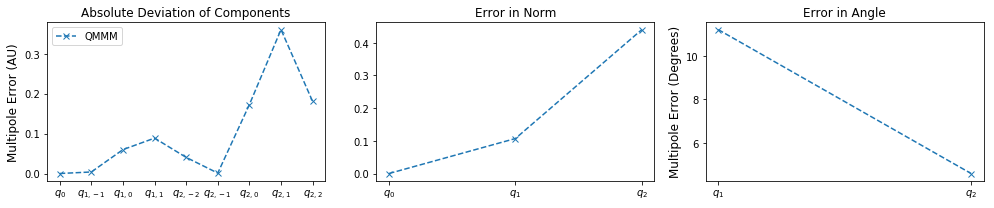

In [34]:
plot_error(molsys["WAT:1"], {"QMMM":qmmm.sys["WAT:1"]})

## Background Proof of Concept
We suspect that we can compute more accurate multipole values by including the second water in the QM region explicitly. Let's demonstrate this before thinking about buffer generation.

In [35]:
qmmm2 = Result()
qmmm2.inp, qmmm2.sys = setup_qmmm(molsys, full.inp, ["WAT:1", "WAT:2"])
qmmm2.log = code.run(name="qmmm2", input=qmmm2.inp, run_dir=rundir)
btool.set_fragment_multipoles(qmmm2.sys, qmmm2.log)

Creating the yaml input file "spillage_dir/qmmm2.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n qmmm2 -s Yes


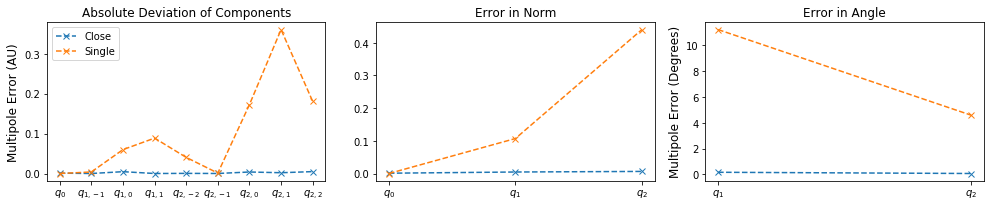

In [36]:
plot_error(molsys["WAT:1"], {"Single":qmmm.sys["WAT:1"], "Close":qmmm2.sys["WAT:1"]})

We need to be judicious in our choice of background. For example, instead of picking the nearby water molecule, what happens if we pick the far one?

In [37]:
qmmm3 = Result()
qmmm3.inp, qmmm3.sys = setup_qmmm(molsys, full.inp, ["WAT:1", "WAT:3"])
qmmm3.log = code.run(name="qmmm3", input=qmmm3.inp, run_dir=rundir)
btool.set_fragment_multipoles(qmmm3.sys, qmmm3.log)

Creating the yaml input file "spillage_dir/qmmm3.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n qmmm3 -s Yes


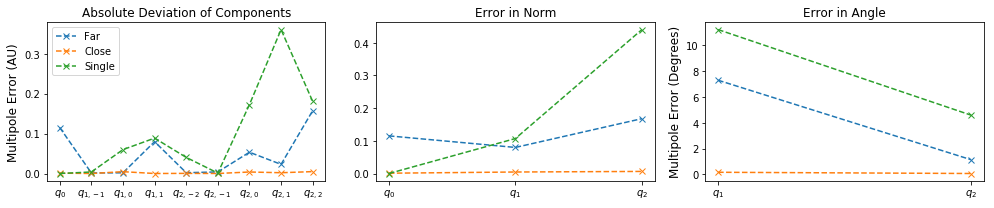

In [38]:
plot_error(molsys["WAT:1"], {"Single":qmmm.sys["WAT:1"], "Close":qmmm2.sys["WAT:1"], "Far":qmmm3.sys["WAT:1"]})

The above graph shows how a judicious choice of background element is crucial to reduce the error.

## Spillage Calculations
The choice of background is important, and we need a way to automatically determine it. The spillage interaction calculator provides precisely this. It returns an array which shows the spillage between the target fragment and all other fragments.

In [39]:
from BigDFT import Spillage as SP
reload(PP)
reload(SP)

<module 'BigDFT.Spillage' from '/Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/lib/python2.7/site-packages/BigDFT/Spillage.pyc'>

{'WAT:3': 0.0, 'WAT:2': 0.03207121464753443, 'WAT:1': 1.0}


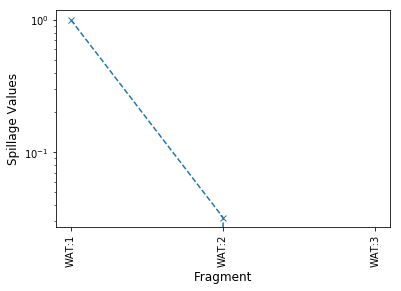

In [40]:
fig, axs = plt.subplots(1,1)
btool = PP.BigDFTool()
spillage_values = btool.compute_spillage(molsys, full.log, "WAT:1")
btool.plot_spillage(axs, spillage_values)
print(spillage_values)

Thus we see that the first water molecule has significant spillage with itself, and the second water molecule, making it a good choice for the buffer. 

## Spillage Application
We have already seen how the spillage value was able to correctly predict that the nearby water molecule should have a significant effect on the observables of our system. This was of course no surprise. Now we turn our attention to some more interesting applications.

### Background Choice
First, we will consider a similar situation, where we are trying to determine the best choice of background. In this case, we will have a more interesting system. We will have two water molecules, at a distance, and one helium molecule nearby. Which molecule should we include in our background?

In [41]:
MixSys = Result()
MixSys.sys = F.System()
MixSys.sys["WAT:1"] = F.Fragment()
MixSys.sys["WAT:1"].append({"O":[-0.931477999671, 0.004547999723, -0.117331000086], "units":"angstroem"})
MixSys.sys["WAT:1"].append({"H":[-1.355753693973, -0.032108553467, 0.725181911626], "units":"angstroem"})
MixSys.sys["WAT:1"].append({"H":[-0.003078395366, 0.011003111969, 0.053703839371], "units":"angstroem"})
MixSys.sys["WAT:2"] = F.Fragment()
MixSys.sys["WAT:2"].append({"O":[2.500000000000, -0.003706000000, 0.113495000000], "units":"angstroem"})
MixSys.sys["WAT:2"].append({"H":[2.796831000000, 0.762122000000, -0.351887000000], "units":"angstroem"})
MixSys.sys["WAT:2"].append({"H":[2.773536000000, -0.747744000000, -0.399151000000], "units":"angstroem"})
MixSys.sys["Ne:1"] = F.Fragment()
MixSys.sys["Ne:1"].append({"Ne":[-2.500000000000, -0.003706000000, 0.113495000000], "units":"angstroem"})

First we will do the full calculation

In [42]:
MixSys.inp = I.Inputfile()
MixSys.inp.set_xc("PBE")
MixSys.inp.set_hgrid(0.4)
MixSys.inp.write_orbitals_on_disk()
MixSys.inp.calculate_dipole()
MixSys.inp["import"] = "linear"
MixSys.inp["posinp"] = {"units":"angstroem", "positions":MixSys.sys.get_posinp("angstroem")}

In [43]:
MixSys.log = code.run(name="MixSys", input=MixSys.inp, run_dir=rundir)
MixSys.sys.set_atom_multipoles(MixSys.log)

Creating the yaml input file "spillage_dir/MixSys.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n MixSys -s Yes


In [44]:
btool = PP.BigDFTool()
btool.set_fragment_multipoles(MixSys.sys, MixSys.log)

First we'll look at the purity values.

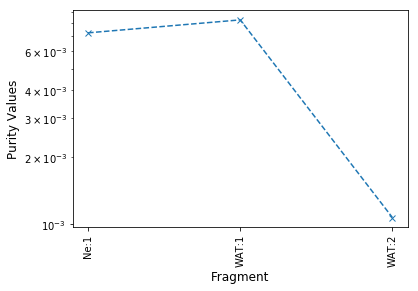

In [45]:
fig, axs = plt.subplots(1,1)
MixSys.sys.plot_purity(axs)

Which confirms that our fragmentation is working as expected. Now we can look at the spillage values:

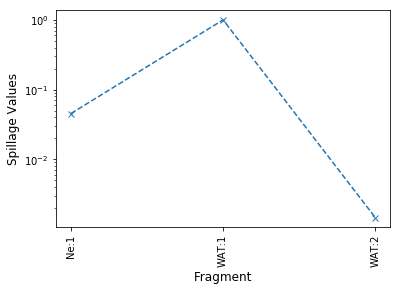

In [46]:
fig, axs = plt.subplots(1,1)
spillage_values = btool.compute_spillage(MixSys.sys, MixSys.log, "WAT:1")
btool.plot_spillage(axs, spillage_values)

This would suggest that it is more important to include the neon atom than the water molecule. Let's test out this result.

In [47]:
h2o2 = Result()
h2o2.inp, h2o2.sys = setup_qmmm(MixSys.sys, MixSys.inp, ["WAT:1", "WAT:2"])
h2o2.log = code.run(name="h2o2", input=h2o2.inp, run_dir=rundir)
btool.set_fragment_multipoles(h2o2.sys, h2o2.log)

Creating the yaml input file "spillage_dir/h2o2.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n h2o2 -s Yes


In [48]:
h2one = Result()
h2one.inp, h2one.sys = setup_qmmm(MixSys.sys, MixSys.inp, ["WAT:1", "Ne:1"])
h2one.log = code.run(name="h2one", input=h2one.inp, run_dir=rundir)
btool.set_fragment_multipoles(h2one.sys, h2one.log)

Creating the yaml input file "spillage_dir/h2one.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/ClassDesign/Build/install/bin/bigdft -n h2one -s Yes


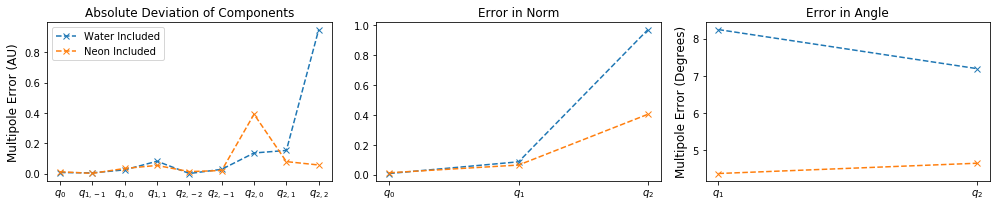

In [49]:
plot_error(MixSys.sys["WAT:1"], {"Water Included":h2o2.sys["WAT:1"], "Neon Included":h2one.sys["WAT:1"]})